In [1]:
import os
import glob
from keras.models import Model
from keras.layers import *
from keras.utils import get_file
import keras.backend as K
import numpy as np
import tensorflow as tf
import pandas as pd
from math import sin, cos
import math
import cv2
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint
from keras.backend.tensorflow_backend import set_session, clear_session
from operator import itemgetter
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.transform import Rotation as R
from tqdm.notebook import tqdm
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

Using TensorFlow backend.


In [2]:
def get_model_n(bn_train=False, bn_train2=False):
    
    def hourglass_module(heads, bottom, cnv_dim, hgid, dims, input_ref):
        lfs = left_features(bottom, hgid, dims)
        rf1 = right_features(lfs, hgid, dims)
        rf1 = convolution(rf1, 3, cnv_dim, name='cnvs.%d' % hgid)
        heads = create_heads(heads, rf1, hgid, input_ref)
        return heads, rf1

    def convolution(_x, k, out_dim, name, stride=1):
        padding = (k - 1) // 2
        _x = ZeroPadding2D(padding=padding, name=name + '.pad')(_x)
        _x = Conv2D(out_dim, k, strides=stride, use_bias=False, name=name + '.conv')(_x)
        if name[:6]=='cnvs.1' and bn_train2==True:
            #print(name + '.bn')
            _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x)
        else:
            _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x, training=bn_train)
        _x = Activation('relu', name=name + '.relu')(_x)
        return _x

    def residual(_x, out_dim, name, stride=1):
        shortcut = _x
        num_channels = K.int_shape(shortcut)[-1]
        _x = ZeroPadding2D(padding=1, name=name + '.pad1')(_x)
        _x = Conv2D(out_dim, 3, strides=stride, use_bias=False, name=name + '.conv1')(_x)

        if (name[:9]=='kps.1.out' or  name[:10]=='kps.1.skip') and bn_train2==True:
            #print(name + '.bn1')
            _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x)
        else:
            _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x, training=bn_train)
        _x = Activation('relu', name=name + '.relu1')(_x)

        _x = Conv2D(out_dim, 3, padding='same', use_bias=False, name=name + '.conv2')(_x)
        if (name[:9]=='kps.1.out' or  name[:10]=='kps.1.skip') and bn_train2==True:
            #print(name + '.bn2')
            _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x)
        else:
            _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x, training=bn_train)

        if num_channels != out_dim or stride != 1:
            shortcut = Conv2D(out_dim, 1, strides=stride, use_bias=False, name=name + '.shortcut.0')(
                shortcut)
            shortcut = BatchNormalization(epsilon=1e-5, name=name + '.shortcut.bn1')(shortcut, training=bn_train)

        _x = Add(name=name + '.add')([_x, shortcut])
        _x = Activation('relu', name=name + '.relu')(_x)
        return _x

    def pre(_x, num_channels):
        _x = convolution(_x, 7, 128, name='pre.0', stride=2)
        _x = residual(_x, num_channels, name='pre.1', stride=2)
        return _x

    def left_features(bottom, hgid, dims):
        features = [bottom]
        for kk, nh in enumerate(dims):
            pow_str = ''
            for _ in range(kk):
                pow_str += '.center'
            _x = residual(features[-1], nh, name='kps.%d%s.down.0' % (hgid, pow_str), stride=2)
            _x = residual(_x, nh, name='kps.%d%s.down.1' % (hgid, pow_str))
            features.append(_x)
        return features

    def connect_left_right(left, right, num_channels, num_channels_next, name):
        left = residual(left, num_channels_next, name=name + 'skip.0')
        left = residual(left, num_channels_next, name=name + 'skip.1')
        out = residual(right, num_channels, name=name + 'out.0')
        out = residual(out, num_channels_next, name=name + 'out.1')
        out = UpSampling2D(name=name + 'out.upsampleNN')(out)
        out = Add(name=name + 'out.add')([left, out])
        return out

    def bottleneck_layer(_x, num_channels, hgid):
        pow_str = 'center.' * 5
        _x = residual(_x, num_channels, name='kps.%d.%s0' % (hgid, pow_str))
        _x = residual(_x, num_channels, name='kps.%d.%s1' % (hgid, pow_str))
        _x = residual(_x, num_channels, name='kps.%d.%s2' % (hgid, pow_str))
        _x = residual(_x, num_channels, name='kps.%d.%s3' % (hgid, pow_str))
        return _x

    def right_features(leftfeatures, hgid, dims):
        rf = bottleneck_layer(leftfeatures[-1], dims[-1], hgid)
        for kk in reversed(range(len(dims))):
            pow_str = ''
            for _ in range(kk):
                pow_str += 'center.'
            rf = connect_left_right(leftfeatures[kk], rf, dims[kk], dims[max(kk - 1, 0)], name='kps.%d.%s' % (hgid, pow_str))
        return rf
    
    def hm_stop_gradient(x):
        return K.stop_gradient(K.sigmoid(x))

    def stop_gradient(x):
        return K.stop_gradient(x)

    def create_heads(heads, rf1, hgid, input_ref):

        _heads = []
        keys = list(heads.keys())  

        if hgid >= 0:
            head = keys[0]
            num_channels = heads[head]
            _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(rf1)
            _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
            _x = Conv2D(num_channels, 1, use_bias=True, name=head[0] + '%d' % hgid)(_x)
            _heads.append(_x)

        hm = Lambda(hm_stop_gradient, name='hm_ref.'+ '%d' % hgid)(_heads[0])
        hm = Concatenate()([rf1, hm])

        if hgid >= 0:
            head = keys[1]
            num_channels = heads[head]
            _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(hm)
            _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
            _x = Conv2D(num_channels, 1, use_bias=True, name=head[0] + '%d' % hgid)(_x)
            _heads.append(_x) 

        if hgid >= 0:
            head = keys[2]
            num_channels = heads[head]
            #_x = Lambda(stop_gradient, name=head + '.%d.stop_g' % hgid)(hm)
            _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(hm)
            _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
            _x = Conv2D(num_channels, 1, use_bias=True, name=head[0] + '%d' % hgid)(_x)
            _heads.append(_x)

        if hgid >= 0:
            head = keys[-1]
            num_channels = heads[head]
            head = '%d'%hgid + head

            ref = input_ref#Lambda(get_ref, name='coor_ref')(_heads[-1])
            ref = Conv2D(16, 1, use_bias=True, padding='same', name=head + '.ref.%d.0.conv' % hgid)(ref)
            #ref = BatchNormalization(epsilon=1e-5, name=head + '.ref.%d.0.bn' % hgid)(ref)
            ref = Activation('relu', name=head + '.ref.%d.0.relu' % hgid)(ref)
            ref = Conv2D(128, 1, use_bias=True, padding='same', name=head + '.ref.%d.1.conv' % hgid)(ref)
            #ref = BatchNormalization(epsilon=1e-5, name=head + '.ref.%d.1.bn' % hgid)(ref)
            ref = Activation('relu', name=head + '.ref.%d.1.relu' % hgid)(ref)

            _x = Concatenate()([hm, ref])

            for i in range(3):
                _x = Conv2D(256*(1+hgid), 3, use_bias=True, padding='same', name=head + '.%d.%d.conv' %(hgid,i))(_x)
                _x = Activation('relu', name=head + '.%d.%d.relu' %(hgid,i))(_x)
            _x = Conv2D(num_channels, 1, use_bias=True, name=head[1] + '%d' % hgid)(_x)
            _heads.append(_x)

        return _heads
    
    def HourglassNetwork(heads, num_stacks=2, cnv_dim=256, inres=(512, 512), weights='ctdet_coco',
                         dims=[256, 384, 384, 384, 512]):

        if not (weights in {'ctdet_coco', 'hpdet_coco', None} or os.path.exists(weights)):
            raise ValueError('The `weights` argument should be either '
                             '`None` (random initialization), `ctdet_coco` '
                             '(pre-trained on COCO), `hpdet_coco` (pre-trained on COCO) '
                             'or the path to the weights file to be loaded.')
        input_ref = Input(shape=(inres[2], inres[3], 2), name='HGRef')
        input_layer = Input(shape=(inres[0], inres[1], 3), name='HGInput')
        inter = pre(input_layer, cnv_dim)
        prev_inter = None
        outputs = []
        for i in range(num_stacks):
            prev_inter = inter
            _heads, inter = hourglass_module(heads, inter, cnv_dim, i, dims, input_ref)
            outputs.extend(_heads)
            if i < num_stacks - 1:
                inter_ = Conv2D(cnv_dim, 1, use_bias=False, name='inter_.%d.0' % i)(prev_inter)
                inter_ = BatchNormalization(epsilon=1e-5, name='inter_.%d.bn1' % i)(inter_, training=bn_train)

                cnv_ = Conv2D(cnv_dim, 1, use_bias=False, name='cnv_.%d.0' % i)(inter)
                cnv_ = BatchNormalization(epsilon=1e-5, name='cnv_.%d.bn1' % i)(cnv_, training=bn_train)

                inter = Add(name='inters.%d.inters.add' % i)([inter_, cnv_])
                inter = Activation('relu', name='inters.%d.inters.relu' % i)(inter)
                inter = residual(inter, cnv_dim, 'inters.%d' % i)

        model = Model(inputs=[input_layer, input_ref], outputs=outputs)
        
        if 0:
            if weights == 'ctdet_coco':
                weights_path = get_file(
                    '%s_hg.hdf5' % weights,
                    CTDET_COCO_WEIGHTS_PATH,
                    cache_subdir='models',
                    file_hash='ce01e92f75b533e3ff8e396c76d55d97ff3ec27e99b1bdac1d7b0d6dcf5d90eb')
                model.load_weights(weights_path, by_name=True)
            elif weights == 'hpdet_coco':
                weights_path = get_file(
                    '%s_hg.hdf5' % weights,
                    HPDET_COCO_WEIGHTS_PATH,
                    cache_subdir='models',
                    file_hash='5c562ee22dc383080629dae975f269d62de3a41da6fd0c821085fbee183d555d')
                model.load_weights(weights_path)
            elif weights is not None:
                model.load_weights(weights)

        return model
    
    heads = {'classes': 34, 'hm_car': 1, 'reg_car': 2, 'dof_car': 8}
    model = HourglassNetwork(heads, num_stacks=2, inres=(None,None,None,None))

    train_layers = ['kps.1.out', 'kps.1.skip', 'cnvs.1']

    if bn_train2 == False:
        for layer in model.layers:
            layer.trainable = False
            if layer.name[:4]=='1dof':
                layer.trainable = True
            if layer.name=='d1':
                layer.trainable = True          
    elif bn_train == False:
        for layer in model.layers:
            layer.trainable = False

            for tl in train_layers:
                if layer.name[:len(tl)] == tl :
                    layer.trainable = True

            if layer.name[:4]=='1dof':
                layer.trainable = True
            elif layer.name[:9]=='reg_car.1':
                layer.trainable = True            
            elif layer.name[:8]=='hm_car.1':
                layer.trainable = True        
            elif layer.name[:9]=='classes.1':
                layer.trainable = True  
            elif layer.name[1]=='1':
                layer.trainable = True

            #if layer.trainable == True:
                #print(layer.name)

    return model

In [3]:
def normalize_image(image):
    mean = [0.40789655, 0.44719303, 0.47026116]
    std = [0.2886383, 0.27408165, 0.27809834]
    return (np.float32(image) - mean) / std

def rotateImage(alpha=0, beta=0, gamma=0, dx=1691.5, dy=0):
    
    fx, dx = 2304.5479, dx
    fy, dy = 2305.8757, dy
    
    A1 = np.array([[1/fx,    0, -dx/fx],
                   [0,    1/fy, -dy/fy],
                   [0,       0,      1],
                   [0,       0,      1]])
    
    RX = np.array([[1,          0,           0, 0],
                   [0, cos(alpha), -sin(alpha), 0],
                   [0, sin(alpha),  cos(alpha), 0],
                   [0,          0,           0, 1]])
    
    RY = np.array([[cos(beta),  0,  -sin(beta), 0],
                   [0,          1,           0, 0],
                   [sin(beta),  0,   cos(beta), 0],
                   [0,          0,           0, 1]])
    
    RZ = np.array([[cos(gamma), -sin(gamma), 0, 0],
                   [sin(gamma),  cos(gamma), 0, 0],
                   [0,          0,           1, 0],
                   [0,          0,           0, 1]])
    
    Rot = np.dot(RZ, np.dot(RX, RY))
    
    A2 = np.array([[fx, 0, dx, 0],
                   [0, fy, dy, 0],
                   [0, 0,   1, 0]])
    trans = np.dot(A2,np.dot(Rot, A1))
    
    return trans, Rot

def sigmoid(x):
    x = np.clip(x, -50, None)
    return 1 / (1 + np.exp(-x))

def get_ref(iw=320, ih=128):
    ref = np.reshape(np.arange(0, ih*iw), (ih, iw, -1))
    ref_x = ref % iw
    ref_y = ref // iw
    return np.dstack([ref_x, ref_y])

def postprocess2(pred):
    yaw,px,py,roll,x,y,z,r = pred
    pitch = math.atan2(py, px)
    roll = roll%(np.pi*2)-np.pi
    return yaw, pitch, roll, x*10, y*10, z*10, r*10

def get_xy_from_XYz(X, Y, z):
    x = (X - 1686.2379)*z/2304.5479
    y = (Y - 1354.9849)*z/2305.8757
    return x,y

def get_xyz_from_XYr(X, Y, r):
    r = np.clip(r, 0, None)
    a = (X - 1686.2379)/2304.5479
    b = (Y - 1354.9849)/2305.8757
    z = r/((a*a + b*b + 1)**.5)
    return a*z, b*z, z

def TTA_gen(sub, xo, yo, M, trans=[[0,0,0,0]]):
    
    inputs = []
    input_coor = []
    
    ref = np.reshape(np.arange(0, xo*yo), (yo, xo, -1))
    ref_x = ref % xo
    ref_y = ref // xo
    ref = np.dstack([(ref_x-(xo-1)/2)/100, ref_y/100])

    while True:
        for i in range(len(sub)):    
            image = cv2.imread('../input/pku-autonomous-driving/test_images/%s.jpg'%sub.iloc[i].ImageId)
            mask = cv2.imread('../input/pku-autonomous-driving/test_masks/%s.jpg'%sub.iloc[i].ImageId)
            if mask is not None:
                image = image*(mask<128)            
            image = image[1355:,:,::-1]
            
            for alpha, beta, gamma, flip in trans:
                alpha = alpha*np.pi/180.
                beta  = beta *np.pi/180.
                gamma = gamma*np.pi/180.                
                Mat, Rot = rotateImage(alpha, beta, gamma)
                
                img = cv2.warpPerspective(image.copy(), np.dot(M,Mat), (xo,yo), flags=cv2.INTER_LINEAR)

                if np.random.random()<flip:        
                    img = img[:,::-1]                

                img = normalize_image(img/255.)    

                coor = ref[::4, ::4]

                inputs.append(img)
                input_coor.append(coor)

            tmp_inputs = np.array(inputs)
            tmp_input_coor = np.array(input_coor)
            inputs = []
            input_coor = []
            
            yield [tmp_inputs, tmp_input_coor]
            
def decode3(pred, trans, Mi, xs=640, ys=128, w=None, interpolation=cv2.INTER_LANCZOS4, sel=None):
    hms=0
    masks=0
    masks2=0
    ts=0
    rs=0
    
    msk = np.zeros((ys,xs))
    msk[9:-8,31:-31]=1
    msk = cv2.GaussianBlur(msk,(65,19), 21)
    msk = msk/msk.max()
    
    if sel is None:
        sel = np.arange(len(trans))
        
    if w is None:
        w = np.ones(len(trans))
        
    for i in sel:
        alpha, beta, gamma, flip = trans[i]
        alpha = alpha*np.pi/180.
        beta  = beta *np.pi/180.
        gamma = gamma*np.pi/180.

        Mat, Rot = rotateImage(alpha, beta, gamma, dx=1691.5+2000)
        Ri = np.linalg.inv(Mat)
        Roti = np.linalg.inv(Rot)
        
        Matrix = np.dot(Mf, np.dot(Ri,Mi))
                
        if flip:
            hm = sigmoid(pred[0][i,:,::-1,0])
            t = pred[-1][i,:,::-1,-4:]
            r = pred[-1][i,:,::-1,:4]
            t[:,:,0] = -t[:,:,0]
            r[:,:,2:] = -r[:,:,2:]
        else:
            hm = sigmoid(pred[0][i,:,:,0])
            t = pred[-1][i,:,:,-4:]
            r = pred[-1][i,:,:,:4]

        hm = cv2.warpPerspective(hm, Matrix, (xo//4+sxo*2,yo//4+syo+24), flags=interpolation)
        t = cv2.warpPerspective(t, Matrix, (xo//4+sxo*2,yo//4+syo+24), flags=interpolation)
        r = cv2.warpPerspective(r, Matrix, (xo//4+sxo*2,yo//4+syo+24), flags=interpolation)
        mask = cv2.warpPerspective(msk.copy(), Matrix, (xo//4+sxo*2,yo//4+syo+24))
        
        ti = np.dot(Roti, np.reshape(t, (-1,4)).T).T.reshape(t.shape)
        
        yaw = r[:,:,0]
        pitch = np.arctan2(r[:,:,2], r[:,:,1])
        roll = r[:,:,3]+np.pi
        rr = np.dstack([-pitch, -yaw, -roll])
        
        ri_ = r.copy()
        y,x = np.where(hm>0.01)
        if len(y)>0:
            r1 = R.from_euler('xyz', rr[y,x], degrees=False)
            r2 = R.from_euler('xyz', [beta, -alpha, -gamma], degrees=False).inv()
            ri = (r2*r1).as_euler('xyz')*(-1)
            #ri = ri.reshape(rr.shape)
            ri_[y,x,0] = ri[:,1]
            ri_[y,x,1] = np.cos(ri[:,0])
            ri_[y,x,2] = np.sin(ri[:,0])
            ri_[y,x,3] = ri[:,2]%(np.pi*2)-np.pi

        mask = mask*w[i]
        if i==0:
            mask2 = mask
        else:
            mask2 = mask*(hm>0.01)

        rs = ri_*mask2[...,np.newaxis]+rs
        ts = ti*mask[...,np.newaxis]+ts
        hms = hm*mask+hms
        masks = mask+masks
        masks2 = mask2+masks2
    hms[masks>0] = hms[masks>0]/masks[masks>0]
    ts[masks>0] = ts[masks>0]/masks[...,np.newaxis][masks>0]
    rs[masks2>0] = rs[masks2>0]/masks2[...,np.newaxis][masks2>0]
    return hms, ts, rs, masks

def creat_sub(params, thr=0.3, thr2=0.7, r=1, pwr=1, avg=True, optimize=3, kernel=(3,3), recall_=0, verbose=1, apn=10, M=None, n=2021, x_shift=0, norm_mask=False):

    ref = get_ref()
    sub = pd.read_csv("../input/pku-autonomous-driving/sample_submission.csv")[:n]
    count=np.zeros(len(sub))

    for idx in tqdm(range(len(sub))):
        
        hms = 0
        dofs = 0
        masks = 0
        
        for trans, w, path, Mi, xs, mw in params:

            pred = np.load(path + '/%d.npz'%idx)
            preds = [pred[key] for key in pred]
            hm, tsf, rsf, mask = decode3(preds, trans, Mi, xs=xs, w=w)
            dof = np.dstack([rsf,tsf])
                
            if norm_mask:
                mask = mask/np.max(mask)
                
            mask = mask*mw
            
            hms = hms + hm*mask
            mask = mask[...,np.newaxis]  
            dofs = dofs + dof*mask
            masks = masks + mask
               
        masks[masks==0] = masks[masks==0] + 1e-7
        p = hms/masks[:,:,0]
        dofs = dofs/masks
        
        ih,iw = hm.shape
        reg = get_ref(iw=iw, ih=ih)-[sxo, syo]

        #p = hms
        local_maxi = p*(p == maximum_filter(p,footprint=np.ones(kernel)))>thr
        py,px = np.where(local_maxi)

        if avg:
            markers = measure.label(local_maxi)
            labels_ws = watershed(-p, markers, mask=p>min(thr,thr2))
            scores = []
            pdx = []
            pdy = []
            dof_=[]
            for i in range(1, markers.max()+1):
                y,x = np.where(labels_ws==i)
                score = p[y,x]
                scores.append(score.max())
                score = score*(score >= min(scores[-1]*r, thr2))
                score = score**pwr
                ss = score.sum()
                dof_.append((dofs[y,x]*score[:,np.newaxis]).sum(0)/ss)
                pdx.append(((reg[y,x,0])*score).sum()/ss)
                pdy.append(((reg[y,x,1])*score).sum()/ss)
        else:
            scores = p[py,px]
            pdx = reg[py,px,0]
            pdy = reg[py,px,1]
            dof_= dofs[py,px,:]

        output = np.zeros((len(dof_),7))

        for j in range(len(dof_)):        
            pp = postprocess2(dof_[j])
            output[j,:6] = pp[:6]
            output[j, 2] = (output[j,2]+np.pi)%(np.pi*2)-np.pi
            output[j,-1] = scores[j]

            #if optimize ==3:
            
            X,Y,Z = np.dot(np.linalg.inv(M), [pdx[j]*4, pdy[j]*4, 1])
            X=X/Z+x_shift
            Y=Y/Z+1355
            x1,y1,z1 = get_xyz_from_XYr(X, Y, pp[-1])
            x0,y0    = get_xy_from_XYz(X, Y, pp[-2])
            if optimize ==3:
                output[j,3:5] = (x0+x1)/2,(y0+y1)/2
            else:
                output[j,3:6] = (x0+x1)/2,(y0+y1)/2, (z1+pp[-2])/2
                
        count[idx] = len(dof_)
        sub.iloc[idx].PredictionString = ' '.join(output.reshape(-1).astype('str'))

    print(thr, thr2, r, pwr, avg, optimize, count.sum())
    return sub, count

k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)


In [4]:
y=1650-1355
yy=2400-1355
dx=1000
yo=512
xo=2048

pts1=np.float32([[0+128,y],[3384-128-1,y],[-dx,yy-1],[3384+dx-1,yy-1]])
pts2=np.float32([[0,0],[xo-1,0],[0,yo-1],[xo-1,yo-1]])
M3=cv2.getPerspectiveTransform(pts1,pts2)

pts1=np.float32([[0+128+dx+1000,y],[3384-128-1+dx+1000,y],[0+1000,yy-1],[3384+dx-1+dx+1000,yy-1]])
pts2=np.float32([[0,0],[(xo-1)/4,0],[0,(yo-1)/4],[(xo-1)/4,(yo-1)/4]])
Mi3=cv2.getPerspectiveTransform(pts2,pts1)

y=1650-1355
yy=2400-1355
dx=2000
yo=512
xo=2560
pts1=np.float32([[0+128,y],[3384-128-1,y],[-dx,yy-1],[3384+dx-1,yy-1]])
pts2=np.float32([[0,0],[xo-1,0],[0,yo-1],[xo-1,yo-1]])
M=cv2.getPerspectiveTransform(pts1,pts2)

syo=128
sxo=64
pts1=np.float32([[0+128+dx,y],[3384-128-1+dx,y],[0,yy-1],[3384+dx-1+dx,yy-1]])
pts2=np.float32([[0,0],[(xo-1)/4,0],[0,(yo-1)/4],[(xo-1)/4,(yo-1)/4]])
pts3=np.float32([[sxo,syo],[(xo-1)/4+sxo,syo],[sxo,(yo-1)/4+syo],[(xo-1)/4+sxo,(yo-1)/4+syo]])
Mf=cv2.getPerspectiveTransform(pts1, pts3)
Mi2=cv2.getPerspectiveTransform(pts2, pts1)

trans =[[0,0,0], [0,7,0], [0,-7,0], [0,15,5], [0,-15,-5], [1,0,0], [-2,0,0]]
a = np.zeros((len(trans)*2, 4))
a[:,:3] = trans+trans
a[len(trans):,-1] = 1
trans3 = a

trans =[[0,0,0], [0,5,0], [0,-5,0], [0,10,3], [0,-10,-3], [2,0,0], [-5,0,0]]
a = np.zeros((len(trans)*2, 4))
a[:,:3] = trans+trans
a[len(trans):,-1] = 1
trans2 = a

In [5]:
sub = pd.read_csv("../input/pku-autonomous-driving/sample_submission.csv")
model = get_model_n()

path = 'test/v99ap2_n'
if not os.path.exists(path):
    os.makedirs(path)
    
model.load_weights('../input/autonomous-driving-checkpoint/v99ap2_n/001-0.703-0.288-0.154-0.758-0.229-0.164-lr-5.5-b4.h5')                   
gen_test = TTA_gen(sub, 2560, 512, M, trans2)

for i in tqdm(range(10)):
    inputs = next(gen_test)
    preds = model.predict(inputs, batch_size=len(trans))    
    np.savez(path + '/%d.npz'%i, *preds[-3:])
    
path = 'test/v99ap3_n'
if not os.path.exists(path):
    os.makedirs(path)
    
model.load_weights('../input/autonomous-driving-checkpoint/v99ap3_n/001-0.674-0.287-0.156-0.636-0.229-0.167-lr-5.5-b4.h5')                   
gen_test = TTA_gen(sub, 2048, 512, M3, trans3)

for i in tqdm(range(10)):
    inputs = next(gen_test)
    preds = model.predict(inputs, batch_size=len(trans))    
    np.savez(path + '/%d.npz'%i, *preds[-3:])

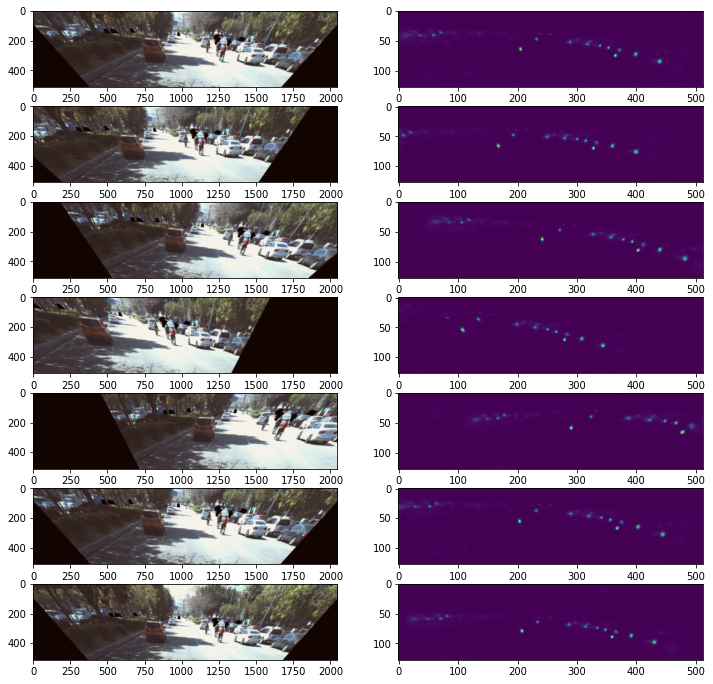

In [6]:
plt.figure(figsize=(12,12))
for i in range(7):
    plt.subplot(7,2,i*2+1)
    img = inputs[0][i]
    plt.imshow((img-img.min())/(img.max()-img.min()), interpolation='bilinear')
    plt.subplot(7,2,i*2+2)
    plt.imshow(sigmoid(preds[-3][i,:,:,0]), interpolation='bilinear')

In [7]:
w=[2,1,1,1,1,1,1,2,1,1,1,1,1,1]
params = [[trans3, w, 'test/v99ap3_n', Mi3, 512, 1],
          [trans2, w, 'test/v99ap2_n', Mi2, 640, 1]]
sub_df, count = creat_sub(params, 0.3, 0.7, 1, 2, avg=True, optimize=3, kernel=(3,3), M=M, n=10)


0.3 0.7 1 2 True 3 87.0


In [8]:
import json
with open('../input/pku-autonomous-driving/car_models_json/mazida-6-2015.json') as json_file:
    data = json.load(json_file)
vertices = np.array(data['vertices'])
vertices[:, 1] = -vertices[:, 1]
triangles = np.array(data['faces']) - 1

im_color = cv2.applyColorMap(np.arange(256).astype('uint8') , cv2.COLORMAP_HSV)[:,0,:]

def draw_obj(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
        cv2.fillConvexPoly(image, coord, color)
        #cv2.polylines(image, np.int32([coord]), 1, color)
        
def draw_car(yaw, pitch, roll, x, y, z, overlay, color=(0,0,255)):
    yaw, pitch, roll = -pitch, -yaw, -roll
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    P = np.ones((vertices.shape[0],vertices.shape[1]+1))
    P[:, :-1] = vertices
    P = P.T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    draw_obj(overlay, img_cor_points, triangles, color)

    return overlay

def show_res(idx, pred_df, ht=1355, hb=2710, size=12, img_only=False):

    img = cv2.imread('../input/pku-autonomous-driving/test_images/%s.jpg'%pred_df.iloc[idx].ImageId)[:,:,::-1]
    mask = cv2.imread('../input/pku-autonomous-driving/test_masks/%s.jpg'%pred_df.iloc[idx].ImageId)
        
    if mask is not None:
        img = img*(mask<128)
        
    overlay = np.zeros_like(img)
    
    pred_string = pred_df.iloc[idx].PredictionString
    
    if not isinstance(pred_string, str) or img_only:
        plt.figure(figsize=(20,size))
        plt.imshow(img[ht:hb])
        return
    
    items = pred_string.split(' ')
    items = np.array(items, dtype='float')
    yaws, pitches, rolls, xs, ys, zs, scores = [items[i::7] for i in range(7)]   

    for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
        color = im_color[np.random.randint(256)].tolist()
        overlay = draw_car(yaw, pitch, roll, x, y, z, overlay, color)
    
    #img[overlay>0] = img[overlay>0]//2 + overlay[overlay>0]//2
    img = (np.maximum(overlay, img)//2 + img//2)
    #img = overlay//2 + img//2
    
    plt.figure(figsize=(20,size))
    plt.imshow(img[ht:hb])
    
    
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

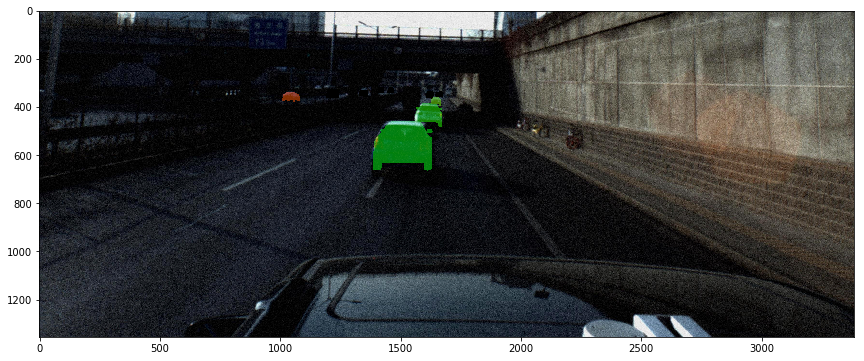

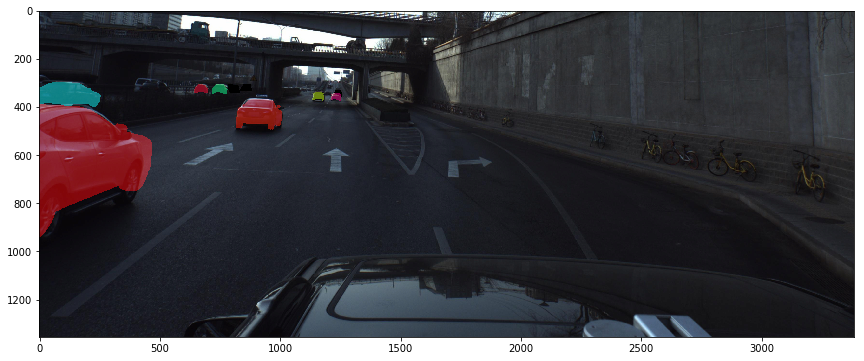

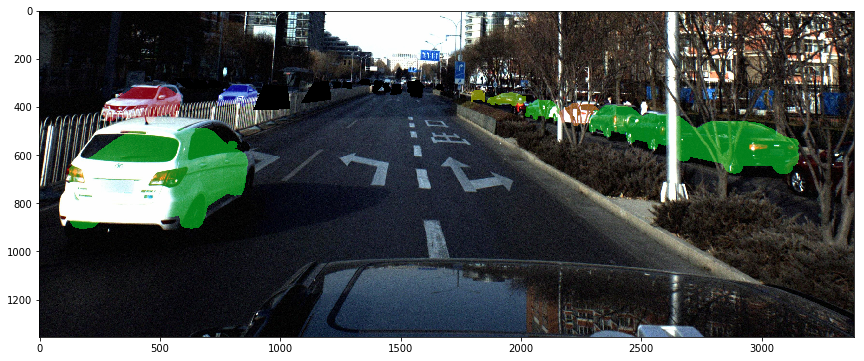

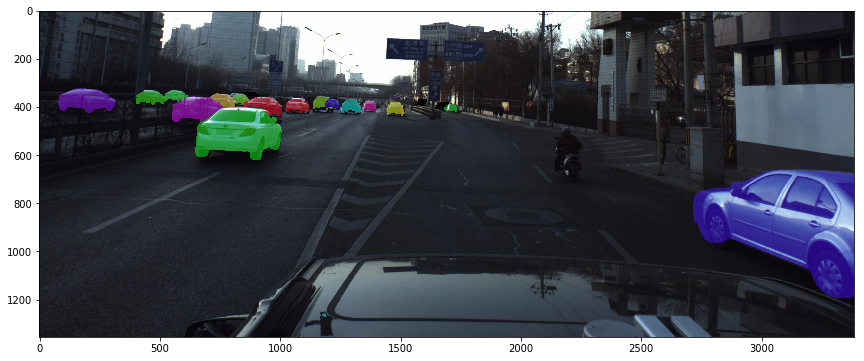

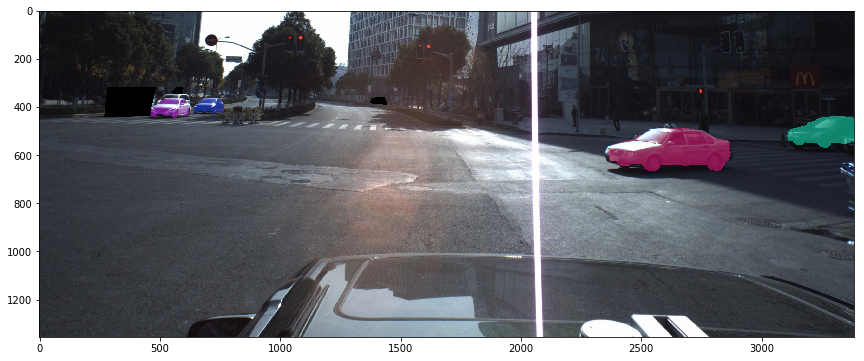

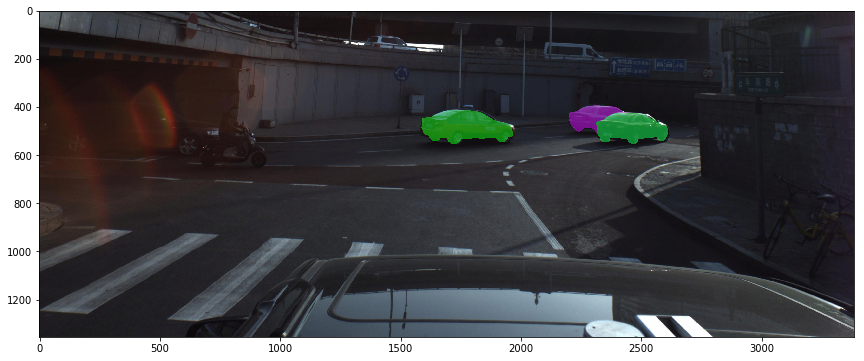

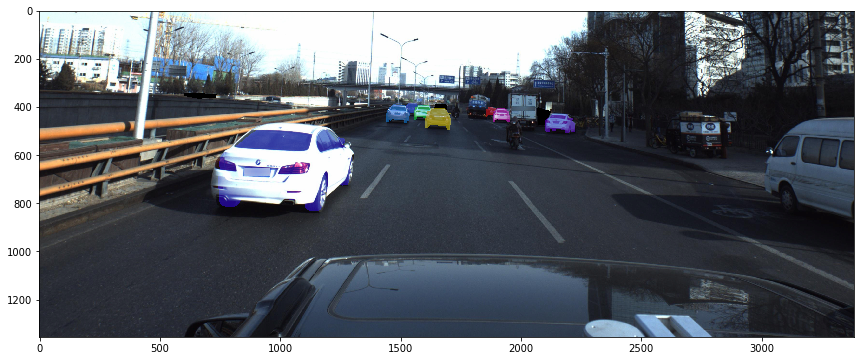

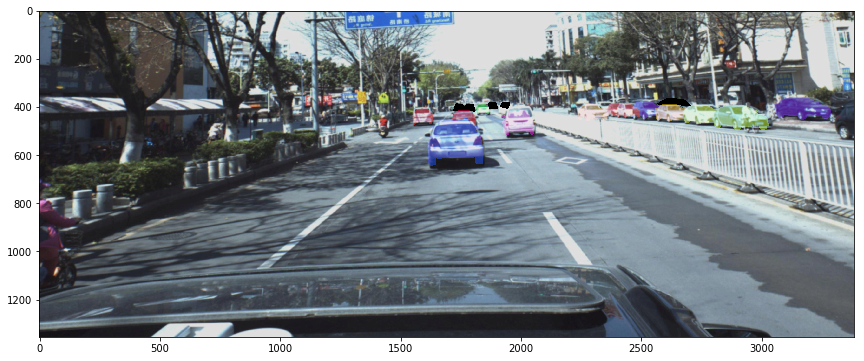

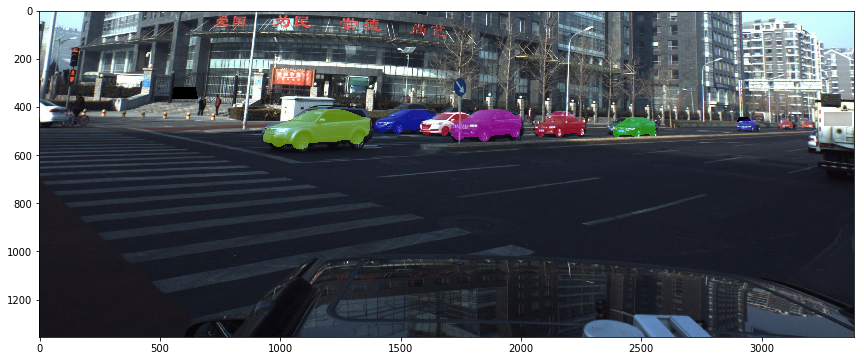

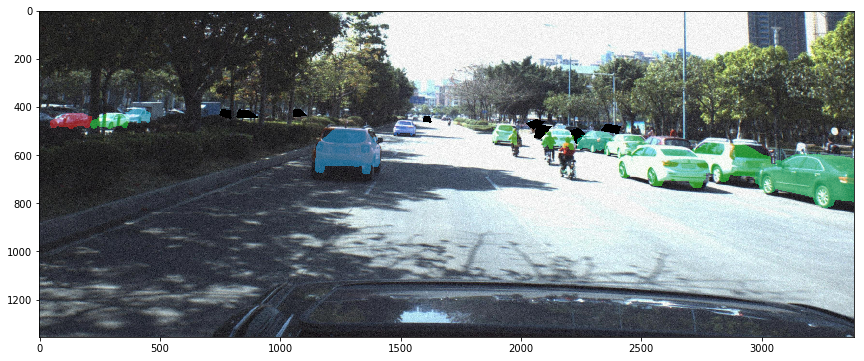

In [9]:
for i in range(10):
    show_res(i, sub_df, ht=1355, hb=2710, size=6)